In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from fredapi import Fred
import yfinance as yf
from dotenv import load_dotenv
import os


In [2]:
fred =Fred(os.getenv("fred_api"))

In [3]:
def series_fred(fred, series_dict):
    data= pd.DataFrame()
    for code, name in series_dict.items():
        data[name] = fred.get_series(code, frequency = 'm')
    return data


In [4]:
series={'SAHMCURRENT':'sahm_rule',
        'VIXCLS':'vix',
        'T10Y2Y':'T10Y2Y',
        'T10Y3M':'T10Y3M',
        'INDPRO':'INDPRO',
        'CPIAUCSL':'CPI',
        'PCE':'PCE'
        }

In [5]:
sp_500 = yf.download(tickers='^GSPC', start='1990-01-01', end='2025-10-05', interval='1mo', auto_adjust=True)['Close']
sp_500 = sp_500.round(4)

[*********************100%***********************]  1 of 1 completed


In [6]:
data = series_fred(fred, series)
data = pd.merge(data, sp_500, left_index=True, right_index=True, how='left')
data['sahm_dummy'] = (data['sahm_rule'] > 0.5).astype(int)
data['PCE'] = np.log(data['PCE'])
data['^GSPC'] = data['^GSPC'].pct_change()
data = data.dropna(axis=0)
#data = data.loc['2007-12-01':'2009-06-06']
data

,sahm_rule,vix,T10Y2Y,T10Y3M,INDPRO,CPI,PCE,^GSPC,sahm_dummy
1990-02-01,0.23,23.26,0.10,0.47,62.1951,128.000,8.223681,0.008539,0
1990-03-01,0.17,20.06,-0.04,0.42,62.4916,128.600,8.230817,0.024255,0
1990-04-01,0.17,21.40,0.06,0.75,62.3511,128.900,8.234830,-0.026887,0
1990-05-01,0.20,18.10,0.12,0.75,62.5353,129.100,8.236368,0.091989,0
1990-06-01,0.10,16.82,0.13,0.49,62.7479,129.900,8.243940,-0.008886,0
...,...,...,...,...,...,...,...,...,...
2025-04-01,0.27,31.97,0.50,-0.04,103.6224,320.321,9.940128,-0.007625,0
2025-05-01,0.27,20.46,0.50,0.06,103.6570,320.580,9.940542,0.061524,0
2025-06-01,0.17,18.40,0.49,-0.04,104.2115,321.500,9.945991,0.049607,0
2025-07-01,0.10,16.38,0.51,-0.02,103.8194,322.132,9.951454,0.021667,0


In [7]:
variables = data.columns
n =  len(variables)


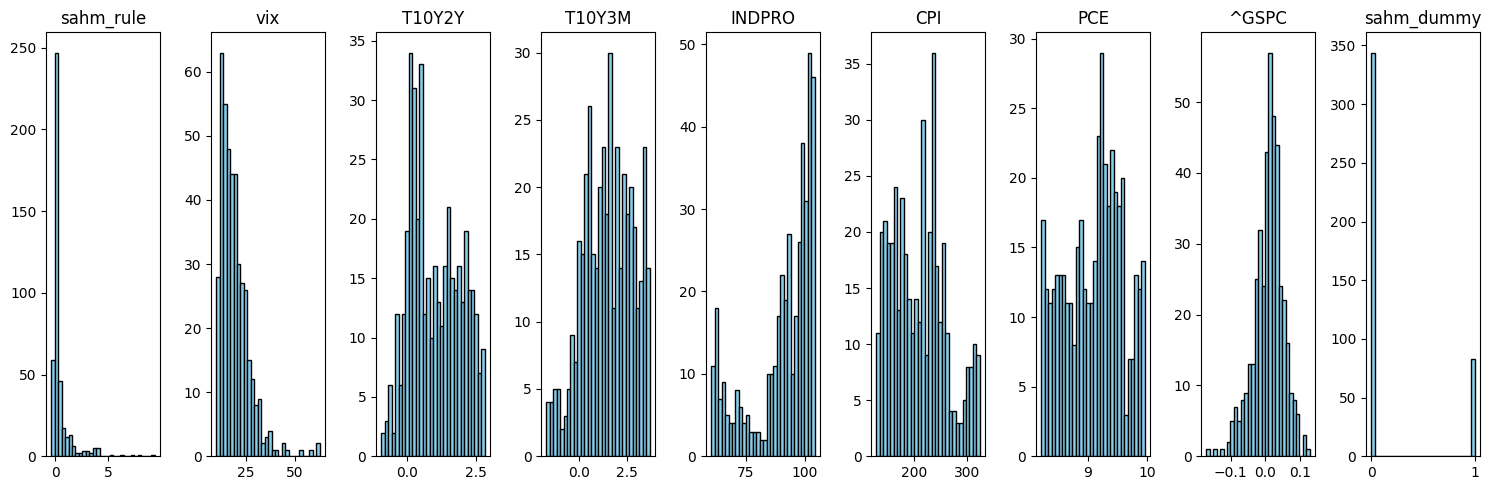

In [8]:
fig, axes = plt.subplots(1, n, figsize=(15,5))

for i, col in enumerate(variables):
    axes[i].hist(data[col], bins=30, color="skyblue", edgecolor="black")
    axes[i].set_title(f"{col}")

plt.tight_layout()
plt.show()

In [9]:
#Modelo Probit
x = data.iloc[:,1:-1]
#x = sm.add_constant(x)
y = data.iloc[:,-1]
probit_model = sm.Probit(y, x)
res = probit_model.fit()

Optimization terminated successfully.
         Current function value: 0.297852
         Iterations 7


In [10]:
print(res.summary())

                          Probit Regression Results                           
Dep. Variable:             sahm_dummy   No. Observations:                  427
Model:                         Probit   Df Residuals:                      420
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.3952
Time:                        11:54:07   Log-Likelihood:                -127.18
converged:                       True   LL-Null:                       -210.30
Covariance Type:            nonrobust   LLR p-value:                 2.822e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vix            0.1009      0.014      7.238      0.000       0.074       0.128
T10Y2Y         0.4549      0.266      1.713      0.087      -0.065       0.975
T10Y3M         0.2308      0.212      1.091      0.2

In [11]:
margeff = res.get_margeff()
print(margeff.summary())

       Probit Marginal Effects       
Dep. Variable:             sahm_dummy
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vix            0.0168      0.002      8.678      0.000       0.013       0.021
T10Y2Y         0.0756      0.043      1.746      0.081      -0.009       0.161
T10Y3M         0.0384      0.035      1.089      0.276      -0.031       0.107
INDPRO        -0.0138      0.002     -6.772      0.000      -0.018      -0.010
CPI            0.0028      0.001      4.693      0.000       0.002       0.004
PCE           -0.0029      0.018     -0.158      0.875      -0.038       0.033
^GSPC          0.3030      0.341      0.890      0.374      -0.365       0.971


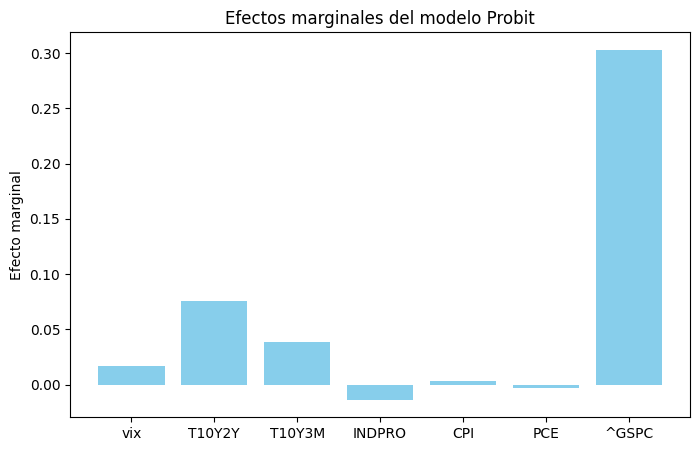

In [12]:
effects = margeff.margeff
variables = x.columns
plt.figure(figsize=(8,5))
plt.bar(variables, effects, color='skyblue')
plt.ylabel("Efecto marginal")
plt.title("Efectos marginales del modelo Probit")
plt.show()

In [13]:
#estadistica descriptiba

describe_stats = data.describe().T.round(4)

In [14]:
#modelo logit

x_logit = data.iloc[:,1:-1]
x_logit = sm.add_constant(x)
y_logit = data.iloc[:,-1]

In [15]:
logit_model = sm.Logit(y,x)
res_logit = logit_model.fit()
print(res_logit.summary())

Optimization terminated successfully.
         Current function value: 0.296588
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             sahm_dummy   No. Observations:                  427
Model:                          Logit   Df Residuals:                      420
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.3978
Time:                        11:54:07   Log-Likelihood:                -126.64
converged:                       True   LL-Null:                       -210.30
Covariance Type:            nonrobust   LLR p-value:                 1.666e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vix            0.1897      0.028      6.759      0.000       0.135       0.245
T10Y2Y         0.6170      0.

In [16]:
#Resultados log_odds

odds_ratio_logit = np.exp(res_logit.params)
print(odds_ratio_logit)

vix        1.208912
T10Y2Y     1.853312
T10Y3M     1.783140
INDPRO     0.861008
CPI        1.031304
PCE        0.945124
^GSPC     32.040863
dtype: float64


In [17]:
#Efectos marginales logit

marginal_logit = res_logit.get_margeff()
print(marginal_logit.summary())

        Logit Marginal Effects       
Dep. Variable:             sahm_dummy
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vix            0.0173      0.002      8.680      0.000       0.013       0.021
T10Y2Y         0.0564      0.043      1.326      0.185      -0.027       0.140
T10Y3M         0.0529      0.036      1.474      0.141      -0.017       0.123
INDPRO        -0.0137      0.002     -6.661      0.000      -0.018      -0.010
CPI            0.0028      0.001      4.680      0.000       0.002       0.004
PCE           -0.0052      0.018     -0.290      0.772      -0.040       0.030
^GSPC          0.3170      0.342      0.927      0.354      -0.353       0.987
